In [1]:
import mmf_setup;mmf_setup.nbinit()
import matplotlib.pyplot as plt
%pylab inline --no-import-all
from nbimports import *
import numpy as np

<IPython.core.display.Javascript object>

In [2]:
import mmf_hfb.BCSCooling as bcsc; reload(bcsc)
from mmf_hfb.BCSCooling import BCSCooling
from mmf_hfb.SolverABM import ABMEvolverAdapter
from mmf_hfb.Cooling import Cooling
from mmf_hfb.Potentials import HarmonicOscillator
from IPython.core.debugger import set_trace
from IPython.display import display, clear_output
import numpy as np
import scipy as sp

def Normalize(psi, dx=0.1):
    return psi/(psi.dot(psi.conj())*dx)**0.5

def Prob(psi):
    return np.abs(psi)**2
   
def check_uv_ir_error(x, psi, plot=False):
    """check if a lattice configuration(N, L, dx) is good"""
    psi_k = np.fft.fft(psi)
    psi_log = np.log10(abs(psi))
    psi_log_k = np.log10(abs(psi_k))
    if plot:
        l, =plt.plot(x,psi_log_k)
        plt.plot(x, psi_log,'--', c=l.get_c())
        print(np.min(psi_log), np.min(psi_log_k))
    assert np.min(psi_log_k) < -15

-17.7887019787572 -inf


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


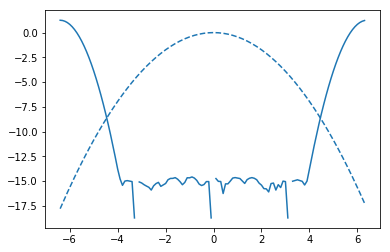

In [3]:
N, dx = 128, 0.1
args = dict(N=N, dx=dx, divs=(1, 1), beta0=1, beta_K=0, beta_V=0, beta_D=0, beta_Y=0, T=0, check_dE=False)
b = BCSCooling(**args)
x = b.xyz[0]
gaussian = np.exp(-x**2)
check_uv_ir_error(x=x, psi=gaussian, plot=True)

In [59]:
def test_cooling(plot_dE=True,  use_ABM=False, T=0.5, **args):   
    b = BCSCooling(**args)
    solver = ABMEvolverAdapter if use_ABM else None
    h0 = HarmonicOscillator(w=1)
    h = HarmonicOscillator()
    da, db=b.divs    
    x = b.xyz[0]
    V = x**2/2
    H0 = b._get_H(mu_eff=0, V=0)
    H1 = b._get_H(mu_eff=0, V=V)
    U0, E0 = b.get_U_E(H0, transpose=True)
    U1, E1 = b.get_U_E(H1, transpose=True)
    psi0 = h.get_wf(x)
    psi0 = U1[0]
    psi0 = Normalize(psi0, dx=b.dx)
    psi = h0.get_wf(x, n=2)
    psi = U0[1]
    psi = Normalize(psi, dx=b.dx)
    #b.erase_max_ks()
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    N0 = psi0.conj().dot(psi0)
    ts, psiss = b.solve([psi], T=T, rtol=1e-5, atol=1e-6, V=V,solver=solver, method='BDF')
    Ns = [_psi.conj().dot(_psi) for _psi in psiss[0]]
    E0, _ = b.get_E_Ns([psi0], V=V)
    Es = [b.get_E_Ns([_psi], V=V)[0] for _psi in psiss[0]]
    dE_dt= [-1*b.get_dE_dt([_psi], V=V) for _psi in psiss[0]]
    plt.plot(x, Prob(psiss[0][0]), "+", label='init')
    plt.plot(x, Prob(psiss[0][-1]), '--',label="final")
    plt.plot(x, Prob(psi0), label='Ground')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    if plot_dE:
        plt.plot(ts[0][:-2], dE_dt[:-2], label='-dE/dt')
        plt.axhline(0, linestyle='dashed')
    plt.legend()
    plt.axhline(0, linestyle='dashed')
    plt.show()    
    return psiss[0][-1]

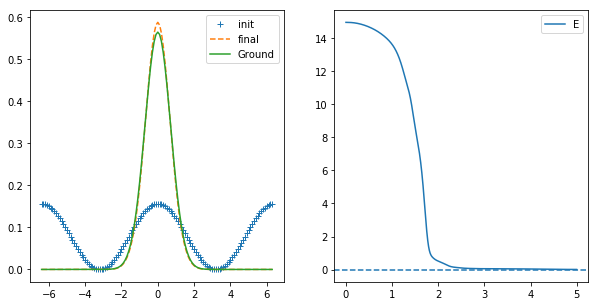

Wall time: 15 s


In [60]:
%%time 
args = dict(N=128, dx=0.1, beta_K=0, beta_V=20, beta_D=0, beta_Y=0, T=5, divs=(1, 1), use_ABM=False, check_dE=False)
psi = test_cooling(plot_dE=False, **args)

In [67]:
def test_imaginary_cooling(plot_dE=True,  use_ABM=False, T=0.5, **args):
    b = BCSCooling(**args)
    solver = ABMEvolverAdapter if use_ABM else None
    h0 = HarmonicOscillator(w=1)
    h = HarmonicOscillator()
    da, db=b.divs    
    x = b.xyz[0]
    V =  x**2/2
    psi_0 = Normalize(np.sqrt(1.0 + 0.2*x*np.exp(-x**2)))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    
    ts, psiss = b.solve([psi_0], T=T, rtol=1e-5, atol=1e-6, V=V,solver=solver, method='BDF')
    psi0 = h0.get_wf(x=x, n=0)
    N0 = psi0.conj().dot(psi0)
    Ns = [_psi.conj().dot(_psi) for _psi in psiss[0]]
    E0, _ = b.get_E_Ns([psi0], V=V)
    Es = [b.get_E_Ns([_psi], V=V)[0] for _psi in psiss[0]]
    dE_dt= [-1*b.get_dE_dt([_psi], V=V) for _psi in psiss[0]]
    plt.plot(x, Prob(psiss[0][0]), "+", label='init')
    plt.plot(x, Prob(psiss[0][-1]), '--',label="final")
    plt.plot(x, Prob(psi0), label='Ground')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    if plot_dE:
        plt.plot(ts[0][:-2], dE_dt[:-2], label='-dE/dt')
        plt.axhline(0, linestyle='dashed')
    plt.legend()
    plt.axhline(0, linestyle='dashed')
    plt.show()    
    return psiss[0][-1]

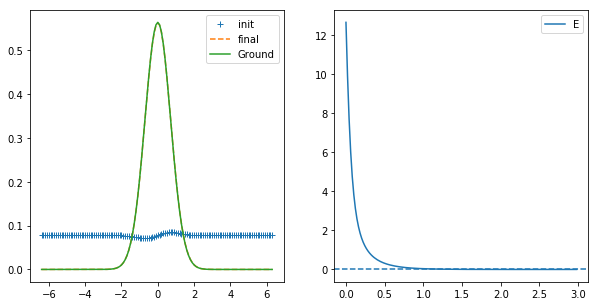

Wall time: 10.3 s


In [69]:
%%time 
args = dict(N=128, dx=0.1,beta_0=-1j, beta_K=0, beta_V=0, beta_D=0, beta_Y=0, T=3, divs=(1, 1), use_ABM=True, check_dE=False)
psi = test_imaginary_cooling(plot_dE=False, **args)

In [6]:
args = dict(N=4, g=1)
egs = [BCSCooling(beta_0=-1j, beta_V=0.0, beta_K=0.0, **args),
       BCSCooling(beta_0=0.0, beta_V=0.0, beta_K=1.0, **args),
       BCSCooling(beta_0=1.0, beta_V=0.0, beta_K=1.0, **args),      
       BCSCooling(beta_0=0.0, beta_V=1.0, beta_K=0.0, **args),
       BCSCooling(beta_0=1.0, beta_V=1.0, beta_K=0.0, **args),
       BCSCooling(beta_0=0.0, beta_V=1.0, beta_K=1.0, **args),
       BCSCooling(beta_0=1.0, beta_V=1.0, beta_K=1.0, **args)]
labels = ['Imaginary Time',
          'K', 'H+K',
          'V', 'H+V',
          'V+K', 'H+V+K']
eg = egs[0]
psi0 = 2*(np.random.random(eg.Nxyz[0]) + 1j*np.random.random(eg.Nxyz[0]) - 0.5 - 0.5j)
V = np.array(psi0)*0
x=egs[0].xyz[0]
#psi0 = 0*x + 1.5 + 1.5*np.exp(-x**2/2)
psi_ground = 0*psi0 + np.sqrt((abs(psi0)**2).mean())
E0, N0 = eg.get_E_Ns([psi_ground], V=V)
Es = [[] for _n in range(len(egs))]
psis = [psi0.copy() for _n in range(len(egs))]
t_max = 3.0
Nstep = 4
Ndata = int(np.round(t_max/eg.dt/Nstep))
ts = np.arange(Ndata)*Nstep*eg.dt
for _n in range(Ndata):
    for n, eg in enumerate(egs):
        ps = [psis[n]]
        ps = eg.step(psis=ps, n=Nstep, V=V)
        psis[n] = ps[0]
        E, N = eg.get_E_Ns(psis=ps, V=V) 
        Es[n].append(E/E0 - 1.0)
Es = np.asarray(Es)

c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


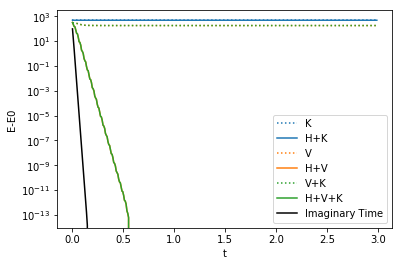

In [7]:
plt.semilogy(ts, Es[1], c='C0', ls=':', label=labels[1])
plt.semilogy(ts, Es[2], c='C0', ls='-', label=labels[2])
plt.semilogy(ts, Es[3], c='C1', ls=':', label=labels[3])
plt.semilogy(ts, Es[4], c='C1', ls='-', label=labels[4])
plt.semilogy(ts, Es[5], c='C2', ls=':', label=labels[5])
plt.semilogy(ts, Es[6], c='C2', ls='-', label=labels[6])
plt.semilogy(ts, Es[0], c='k', ls='-', label=labels[0], scaley=False)
plt.xlabel("t")
plt.ylabel("E-E0")
plt.legend()